<a href="https://colab.research.google.com/github/codewithAshwani/Speech-Recognition-CTC-decoder/blob/main/speech_TransformerEncoder_CTC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import numpy as np
import matplotlib.pyplot as plt
import time
import numpy
from pickle import dump
from pickle import load
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Activation, Bidirectional, Reshape
from tensorflow.keras.layers import Conv2D, MaxPooling2D,TimeDistributed, LSTM

In [ ]:
pickle_path = 'feature.pkl'

In [ ]:
from self_attention_encoder import Encoder

/content/drive/MyDrive/Colab Notebooks/Speech_MNIST_Recognition


In [ ]:
def load_features(filename):
    data = load(open(filename, 'rb'))

    x = data["feauture_mfcc"]
    y = data["mapping"]
    return x,y

In [ ]:
x,y = load_features(pickle_path)

In [ ]:
max_length = max([len(label) for label in y])
max_length

5

In [ ]:
# padding of words which are smaller than max_length, with character '<unk>'
y_padded = []
for i in range(len(y)):
  val = list(y[i])
  while len(val)<(max_length):
    val.append('<unk>')
  y_padded.append(val)
# characters in label
characters = set(char for label in y for char in label)
# dictionary for tokenization of charaters 
char_to_num = dict(zip(sorted(characters) + ['<unk>'], list(range(len(characters) + 1))))
num_to_char = {v:k for k,v in char_to_num.items()}
# convert characters to integer token 
y2=[]
for label in y_padded:
  y2.append([char_to_num[i] for i in label])

In [ ]:
len(characters)

15

In [ ]:
''.join([num_to_char[i] for i in y2[-1]])

'zero<unk>'

In [ ]:
x = np.asarray(x)
x = x.reshape(-1,x.shape[1],x.shape[2],1)
width = x.shape[1]
height = x.shape[2]
width,height

(55, 13)

In [ ]:
# Split the data
x_train, x_valid, y_train, y_valid = train_test_split(x, np.asarray(y2), test_size=0.01, shuffle= True)

In [ ]:
x_train.shape, y_train.shape, x_valid.shape

((2970, 55, 13, 1), (2970, 5), (30, 55, 13, 1))

In [ ]:
BUFFER_SIZE = x_train.shape[0]
BATCH_SIZE = 16
steps_per_epoch = x_train.shape[0]//BATCH_SIZE
beam_widt = 3

dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
BUFFER_SIZE_TEST = x_valid.shape[0]
dataset_test = tf.data.Dataset.from_tensor_slices((x_valid, y_valid)).shuffle(BUFFER_SIZE_TEST)
dataset_test = dataset_test.batch(1)

In [ ]:
for example_x,example_y in dataset:
  print(example_x.shape, example_y.shape)
  break

(16, 55, 13, 1) (16, 5)


In [ ]:
class CNN_Feature(tf.keras.layers.Layer):
    def __init__(self, img_width, img_height):
        super(CNN_Feature, self).__init__()
        self.img_width = img_width
        self.img_height = img_height

        self.Conv2D1 = Conv2D(32,(3, 3), activation="relu", kernel_initializer="he_normal", padding="same", name="Conv1")
        self.MaxPooling2D1 = MaxPooling2D((2, 2), name="pool1")
        self.Conv2D2 = Conv2D(64,(3, 3), activation="relu", kernel_initializer="he_normal", padding="same", name="Conv2")
        self.MaxPooling2D2 = MaxPooling2D((2, 2), name="pool2")

        self.Reshape= Reshape(target_shape=((self.img_width // 4), (self.img_height // 4) * 64), name="reshape")
        self.Dense=Dense(64, activation="relu", name="dense1")

    def call(self, x):
        x = self.Conv2D1(x)
        x = self.MaxPooling2D1(x)
        x = self.Conv2D2(x)
        x = self.MaxPooling2D2(x)
        x = self.Reshape(x)
        output = self.Dense(x)
        return output

In [ ]:
Feature =  CNN_Feature(width,height)
output = Feature(example_x)
embed_size = output.shape[2]
heads      = 4
forward_expansion = embed_size*4
num_layers = 6
max_lengthn = 128
rate=0.1
output.shape, embed_size

(TensorShape([16, 13, 64]), 64)

In [ ]:
class Self_Attention(tf.keras.Model):
      def __init__(self, num_layers, embed_size, heads, forward_expansion, max_length, rate, characters, img_width, img_height):
        super(Self_Attention, self).__init__()
        self.CNNfeature = CNN_Feature(img_width, img_height)

        self.Encodere = Encoder(num_layers, embed_size, heads, forward_expansion, max_length, rate)
        self.Dense1 = TimeDistributed(Dense(len(characters)+1, name="dense2"))
        self.Dense2 = TimeDistributed(Activation('softmax'), name='softmax')


      def call(self, x, training):
        inp = self.CNNfeature(x)

        enc_output = self.Encodere(inp, training, mask=None)
        x = self.Dense1(enc_output)
        output = self.Dense2(x)
        return output

In [ ]:
Self_Attention=Self_Attention(num_layers, embed_size, heads, forward_expansion, max_lengthn, rate, characters, width, height)
outputx = Self_Attention(example_x)
outputx.shape

TensorShape([16, 13, 16])

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=1500, stw=-1.2):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)
    self.stw = stw

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** self.stw)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
learning_rate = CustomSchedule(6000, warmup_steps=1500, stw =-1.2)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

In [ ]:
def CTC_loss(y_true, y_pred):

    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    
    return loss

In [ ]:
@tf.function
def train_step(x_batch_train, y_batch_train):
    loss = 0
    with tf.GradientTape() as tape:
        output = Self_Attention(x_batch_train, True) 
        output = CTC_loss(y_batch_train, output)
        loss = tf.math.reduce_mean(output)
    batch_loss = (loss / y_batch_train.shape[1])   
    variables = Self_Attention.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [ ]:
EPOCHS = 500
history = {
  "epoch": [],
  "loss": []  
}
for epoch in range(EPOCHS):
    start = time.time()
    total_loss = 0
    for step, (x_batch_train, y_batch_train) in enumerate(dataset):
        batch_loss = train_step(x_batch_train, y_batch_train)
        total_loss += batch_loss
    history['epoch'].append(epoch)
    history['loss'].append(total_loss)
    if (epoch + 1) % 50 == 0:
       print(f'Epoch {epoch+1} Loss {total_loss:.4f}')
       print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 50 Loss 21.2547
Time taken for 1 epoch 3.48 sec

Epoch 100 Loss 8.7620
Time taken for 1 epoch 3.47 sec

Epoch 150 Loss 6.0551
Time taken for 1 epoch 3.45 sec

Epoch 200 Loss 4.8886
Time taken for 1 epoch 3.45 sec

Epoch 250 Loss 3.1500
Time taken for 1 epoch 3.49 sec

Epoch 300 Loss 2.5451
Time taken for 1 epoch 3.43 sec

Epoch 350 Loss 2.5719
Time taken for 1 epoch 3.42 sec

Epoch 400 Loss 2.2106
Time taken for 1 epoch 3.52 sec

Epoch 450 Loss 1.8416
Time taken for 1 epoch 3.54 sec

Epoch 500 Loss 1.2071
Time taken for 1 epoch 3.66 sec



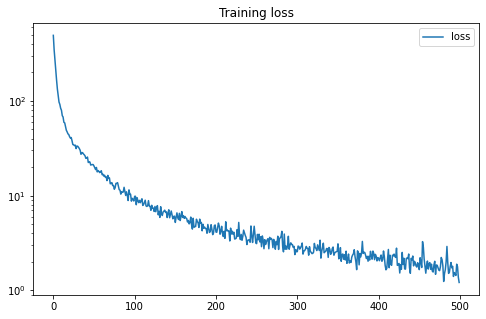

In [ ]:
plt.figure(figsize=(8,5))
plt.yscale("log")
plt.plot(history["epoch"],history["loss"], label='loss')
plt.title('Training loss')
plt.legend(loc='best')
plt.show()

In [ ]:
def greedy_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = tf.keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    resultn = np.array([i for i in tf.reshape(results, [max_length]).numpy() if i!=-1]) 
    output_text = ''.join([num_to_char[i] for i in resultn])
    output_text = ' '.join(output_text.split("|"))
    return output_text

In [ ]:
for i, (x_batch_test, y_batch_test) in enumerate(dataset_test):
    preds = Self_Attention(x_batch_test, False)
    pred_texts = greedy_predictions(preds)
    y_batch = np.array([i for i in tf.reshape(y_batch_test, [max_length]).numpy() if i != (len(characters))]) 
    label_true = ''.join([num_to_char[i] for i in y_batch])
    label_true = ' '.join(label_true.split("|"))
    print(f"\nActual :  {label_true},    Predicted :  {pred_texts}")   


Actual :  two,    Predicted :  two

Actual :  eight,    Predicted :  eight

Actual :  four,    Predicted :  four

Actual :  nine,    Predicted :  nine

Actual :  four,    Predicted :  fouru

Actual :  six,    Predicted :  six

Actual :  three,    Predicted :  three

Actual :  three,    Predicted :  three

Actual :  four,    Predicted :  four

Actual :  one,    Predicted :  one

Actual :  four,    Predicted :  four

Actual :  two,    Predicted :  two

Actual :  one,    Predicted :  one

Actual :  six,    Predicted :  six

Actual :  six,    Predicted :  six

Actual :  two,    Predicted :  two

Actual :  eight,    Predicted :  eight

Actual :  nine,    Predicted :  nine

Actual :  six,    Predicted :  six

Actual :  five,    Predicted :  five

Actual :  two,    Predicted :  two

Actual :  six,    Predicted :  si

Actual :  eight,    Predicted :  eight

Actual :  six,    Predicted :  six

Actual :  three,    Predicted :  three

Actual :  five,    Predicted :  five

Actual :  one,    Predi